### Homework 4 -hint for the Shor' algorithm

<b> Problem 2: Shor' algorith in qiskit </b>

 Design the quantum circuit which can find periods for the modular exponent $a^x (mod N)$ with some small number $a$ and $N$, e.g. $a=3$, $N=10$ or $a=2$, $N=9$. Test the algorithm using qiskit.
 
 <br />

  
<b> Solution </b>
We will use similar approach as in Qiskit tutorial https://qiskit.org/textbook/ch-algorithms/shor.html. 
The key components is the realization of modular exponent $a^x (mod N)$ using qunatum operators. 


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import matplotlib.pyplot as plt 


Let's investigate the period $a^r mod N =1$ analytically

Could not find period, check a < N and have no common factors.


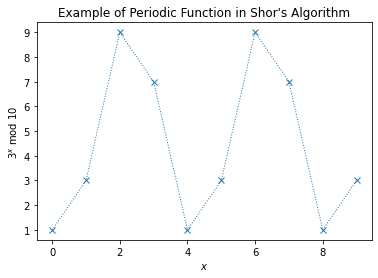

In [63]:
N = 10
a = 3

# Calculate the plotting data
xvals = np.arange(10)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

Inverse QFT from qiskit

In [26]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

The realization of quantum modular multiplication $U_a |y\rangle =  |ay mod N \rangle $ for $y< N$ can be non-trivial in general. We will use the simplified approach based on the fact that the input state to which we apply operators  is $|1\rangle$. Then using e.g. $a=3$ and $N=10$ and $2^5 =32$ in the quantum phase estimation algorithm we note that   $U_a^4 |1\rangle =  |81 mod N \rangle = |1 mod N \rangle $ can be replaced by the identity operator. Next, $U_a^2 |1\rangle= |9 mod N \rangle = |1001 \rangle$ applied to state $|1\rangle$  acts $X_3$. 
Last, for the possible inputs $U_3 1 =3$ and $U_a 9 = |7\rangle$. In binary representation $U_3 0001 = 0011 $,  $U_3 1001 = 0111 $. One can see that such transformation is the same as $Swap(2,1) X_1$. Note that in contrast to the original oparators for $U_a^k$  such reduced operators don't commute so that their order is important.   

In [40]:
def U2():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(3)
    U = U.to_gate()
    U.name = "U2" 
    c_U = U.control()
    return c_U

In [41]:
def U1():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(1)
    U.swap(3,2)
    U = U.to_gate()
    U.name = "U1" 
    c_U = U.control()
    return c_U

In [65]:
# Create QuantumCircuit with n_count=3 counting qubits
# plus 4 qubits for U to act on
## Paste your code here (modify the qiskit textbook example accordingly) to get the following output

┌───┐              ┌───────┐┌─┐      
q_0: ┤ H ├──────────────┤0      ├┤M├──────
     ├───┤              │       │└╥┘┌─┐   
q_1: ┤ H ├───■──────────┤1 QFT† ├─╫─┤M├───
     ├───┤   │          │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───┼──────■───┤2      ├─╫──╫─┤M├
     └───┘┌─┴┼──┐┌─┴┼──┐└───────┘ ║  ║ └╥┘
q_3: ─────┤0 │  ├┤0 │  ├──────────╫──╫──╫─
          │     ││     │          ║  ║  ║ 
q_4: ─────┤1    ├┤1    ├──────────╫──╫──╫─
          │  U2 ││  U1 │          ║  ║  ║ 
q_5: ─────┤2    ├┤2    ├──────────╫──╫──╫─
     ┌───┐│     ││     │          ║  ║  ║ 
q_6: ┤ X ├┤3    ├┤3    ├──────────╫──╫──╫─
     └───┘└─────┘└─────┘          ║  ║  ║ 
c: 3/═════════════════════════════╩══╩══╩═
                                  0  1  2

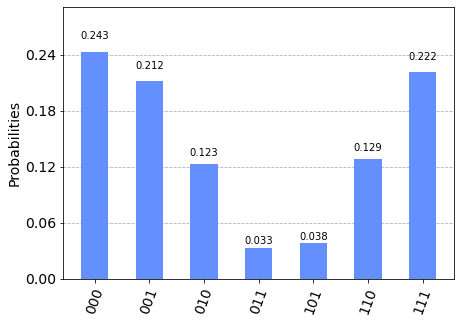

In [54]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Now, post-process these results using the code from qiskit tutorial for the calculation of $r$ using continous fraction expansion 

In [55]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

     Register Output       Phase
0  000(bin) = 0(dec)  0/8 = 0.00
1  001(bin) = 1(dec)  1/8 = 0.12
2  010(bin) = 2(dec)  2/8 = 0.25
3  011(bin) = 3(dec)  3/8 = 0.38
4  101(bin) = 5(dec)  5/8 = 0.62
5  110(bin) = 6(dec)  6/8 = 0.75
6  111(bin) = 7(dec)  7/8 = 0.88


In [57]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.625      5/8            8
5  0.750      3/4            4
6  0.875      7/8            8


Comparing with the above plot one can see that the procedure works. 